# Principled Data Augmentation
Mark van der Wilk, 25 September 2021

Data augmentation is generally explained as adding additional training data by perturbing the
input in a way that is understood to not change the output. From a Bayesian point of view,
this is problematic, as the data that we are given should only influence our inference through
a well-defined likelihood (likelihood principle).

In our paper *Data augmentation in Bayesian neural networks and the cold posterior effect* [1]
we discuss two ways of including data augmentation in a valid way:
1. The invariant model. This involves averaging a function over the data augmentation to
create a new function that is more invariant. This has been used a lot in constructing
invariances, and was used to learn data augmentation parameters in [2].
2. The noisy-input model. This was discussed in appendix K of [3] in the context of data
augmentation, and proposes using a model where the input is corrupted by the data augmentation
process before it is fed into our classification function.

In our paper we discuss ways how to do inference in these models by lower-bounding the
likelihood. Here, I want to illustrate the difference between the behaviour of these models.
Specifically, I choose a setting here where we can do all the computations exactly. So, we use
a Gaussian process prior, and a data augmentation that enforces symmetry around $x=0$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.models import GPR
from gpflow.kernels import Kernel, SquaredExponential
from tools.plotting import plot_1d_model

# Parameters for visualisation
marginal_variance_factor = 0.5
noisestd = 0.1
pX = np.linspace(-6, 6, 40)[:, None]
pdensity = np.linspace(-3, 3, 200)[:, None]
num_samples = 10
X = np.array([[-4.0]])
Y = np.array([[2.5]])

## Invariant Model
We first code up the invariant model. Following [2], we construct GP prior that is invariant to mirroring
about the point $x=0$. This gives us a double-sum kernel:

$
\begin{gather}
g \sim \mathcal{GP}(0, k_\text{base}(x, x'))\\
f(x) = g(x) + g(-x) \\
\implies f \sim \mathcal{GP}\left(0, k(x, x')\right) \\
k(x, x') = \sum_{c \in {1, -1}}\sum_{c' \in {1, -1}} k_\text{base}(cx, c'x')
\end{gather}
$

In [2]:
class SymmetricKernel(Kernel):
    def __init__(self, variance=1.0, lengthscales=1.0, **kwargs):
        super().__init__(**kwargs)
        self.basekern = SquaredExponential(variance, lengthscales, **kwargs)

    def K(self, X, X2=None):
        Xshp = tf.shape(X)
        X = tf.reshape(
            tf.stack([X[:, None, :], -X[:, None, :]], axis=1),  # [N, 2, D]
            (2 * Xshp[0], Xshp[1])
        )  # [N * 2, D]
        if X2 is not None:
            X2shp = tf.shape(X2)
            X2 = tf.reshape(
                tf.stack([X2[:, None, :], -X2[:, None, :]], axis=1),  # [N, 2, D]
                (2 * X2shp[0], X2shp[1])
            )  # [N * 2, D]
        fK = tf.reshape(
            self.basekern.K(X, X2),
            (Xshp[0], 2, -1, 2)
        )
        return tf.reduce_sum(fK, [1, 3]) / 4

    def K_diag(self, X):
        return tf.linalg.diag_part(self.K(X))

Our GP prior is now constrained to *only* contain functions with our desired invariance. Since
everything is encoded in the kernel, we make predictions using the usual posterior. In the
following figures, we plot samples and the predictive density. Notice that we only pass a
single datapoint, and that we obtain generalise to two distant regions!


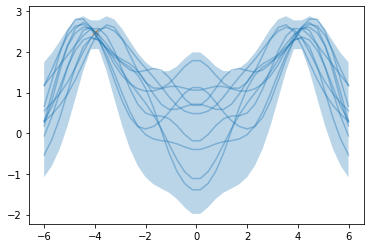

In [3]:
m = GPR((X, Y), SymmetricKernel(lengthscales=1.0, variance=2.0 * marginal_variance_factor))
m.likelihood.variance.assign(noisestd ** 2.0)

plot_1d_model(m, pX=pX, plot_samples=True, plot_var='y', plot_mean=False)

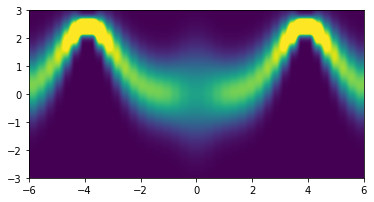

In [4]:
xs, ys = np.meshgrid(pX, pdensity)
d = (np.ravel(xs)[:, None], np.ravel(ys)[:, None])
logdensity = m.predict_log_density(d).numpy()
invariant_density = np.exp(logdensity).reshape(len(pdensity), -1)
plt.imshow(np.flipud(invariant_density), extent=(xs.min(), xs.max(), ys.min(), ys.max()))
plt.clim(0, 0.7)

## Noisy-Input Model
In the noisy-input model, we take the input $x$ and corrupt it using $p(x'|x)$ before passing
$x'$ into the function we learn. TODO: Make graphical model of this (see [3]). In our case,
$p(x'|x)$ may flip $x$ about $x=0$ with probability $0.5$.

Our example noisy-input model:

$
\begin{align}
p(\mathbf y, \mathrm X, f) &= p(f)\prod_n p(y_n|f(x_n')) \cdot p(x_n' | x_n) \\
f &\sim \mathcal{GP} \\
p(x_n'|x_n) &= \frac{1}{2}\delta(x_n' - x_n) + \frac{1}{2}\delta(x_n' + x_n) \\
p(y_n|f(x_n')) &= \mathcal N (y_n; f(x_n'), \sigma^2)
\end{align}
$

So we can find the posterior of one datapoint to be the mixture of 2 GP posteriors.

$
\begin{align}
p(f|x_1, y_1) &= \int \mathrm d x_1'\frac{p(f)p(y_1|f(x_1'))p(x_1'|x_1)}{Z} \\
&= \frac{1}{2}p(f|y_1, x_1) + \frac{1}{2}p(f|y_1, -x_1)
\end{align}
$

Making a prediction would again require marginalising over $x'$ for the test input, but in this
case, this doesn't change anything.

We now visualise the predictive density of $f$. We see that we now have a bimodal predictive density!
This is because our function is now a mixture of GP posteriors that are conditioned on the same
output, but at two different inputs. We knew what the output was, but we were uncertain about
the input.

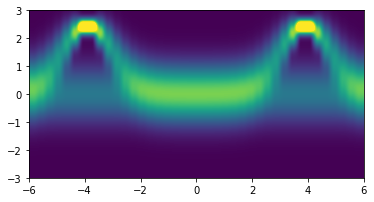

In [5]:
m1 = GPR((X, Y), SquaredExponential(lengthscales=1.0, variance=marginal_variance_factor))
m1.likelihood.variance.assign(noisestd ** 2.0)
m2 = GPR((-X, Y), SquaredExponential(lengthscales=1.0, variance=marginal_variance_factor))
m2.likelihood.variance.assign(noisestd ** 2.0)

xs, ys = np.meshgrid(pX, pdensity)
d = (np.ravel(xs)[:, None], np.ravel(ys)[:, None])
logdensity1 = m1.predict_log_density(d).numpy()
logdensity2 = m2.predict_log_density(d).numpy()
density = (0.5 * np.exp(logdensity1) + 0.5 * np.exp(logdensity2)).reshape(len(pdensity), -1)
plt.imshow(np.flipud(density), extent=(xs.min(), xs.max(), ys.min(), ys.max()))
plt.clim(0, 0.7)

## Detailed comparison
To further illustrate the difference between the two models, we plot samples from both
posteriors, as well as the predictive density at $x=-4$. We see that for the invariant model
all function samples from the posterior are actually invariant. Also, the uncertainty
decreases at the location of the observation ($x=4$), as well as its mirrored location ($x=-4$).

For the noisy-input model, we also plot samples from the posterior. As stated previously, the
posterior is a mixture of GP posteriors. Half of the samples come from each componenent, and
can be distinguished by the linestyle. The solid lines go throught the datapoint at $x=4$,
while the dashed lines go through the observed value at $x=-4$, which corresponds to the model
being uncertain what the actual input to the function was. The functions in our posterior are
not invariant, but the predictive *density* is.

We can compare the predictive densities of the two models in the final figure. The invariant
model has a sharp and narrow prediction at both the data point and its mirrored point, while
the noisy-input models has much more uncertainty.

I would argue that the invariant model behaves more like how we would expect a regression
model with invariances to behave. One interesting open question, is whether the models behave
similarly in a large-data limit.

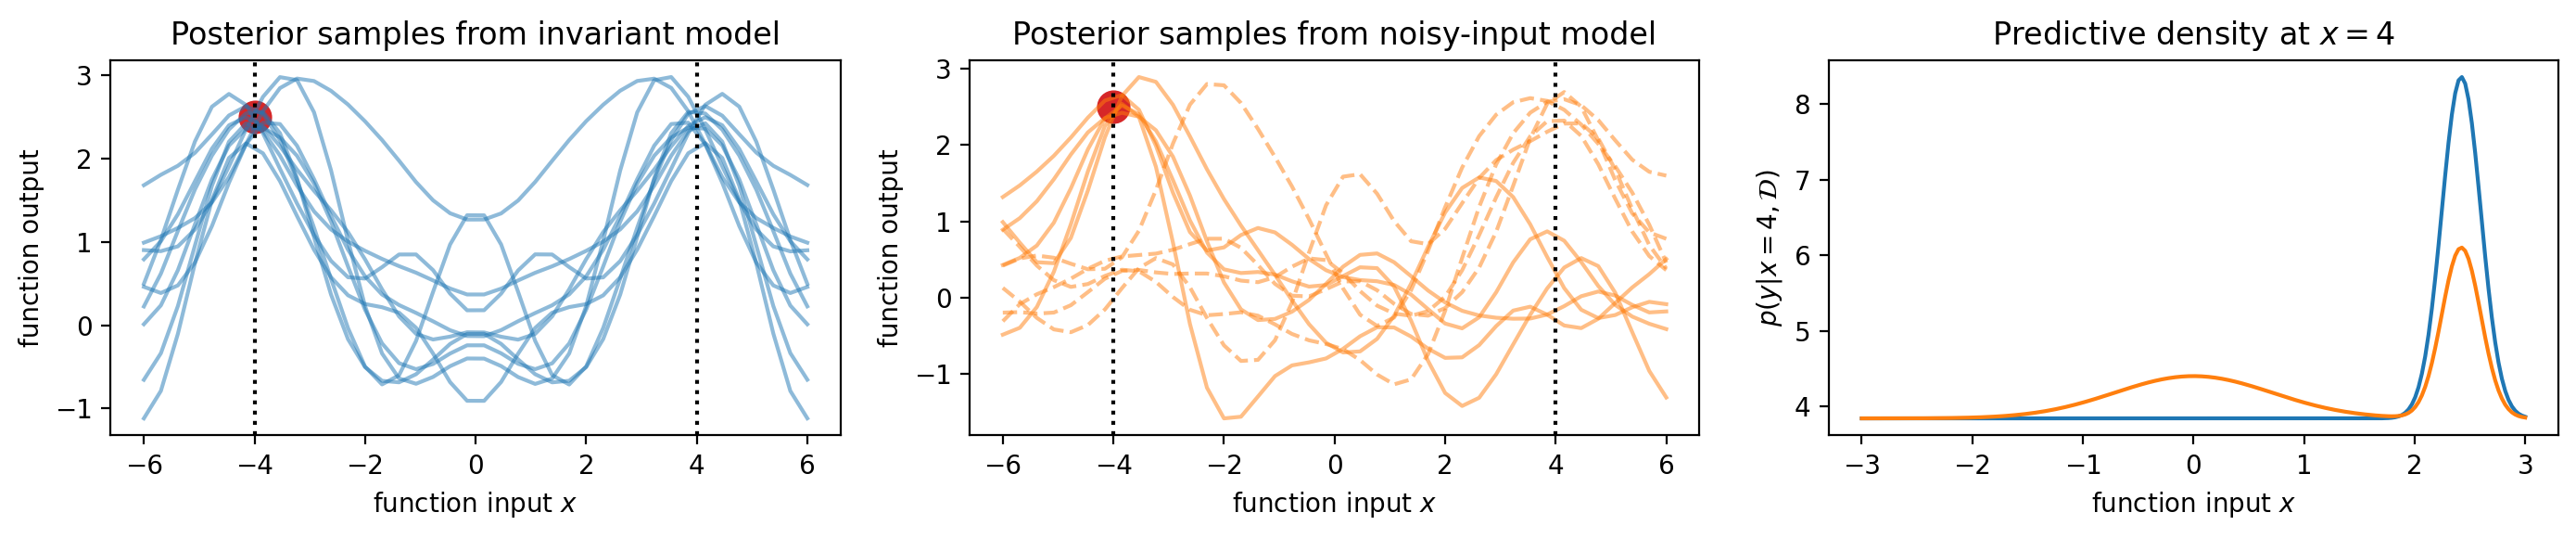

In [6]:
_, (ax1, ax2, ax_density) = plt.subplots(1, 3, figsize=(14, 3), dpi=200)

i = (np.abs(pX - 4)).argmin()
ax_density.plot(pdensity, invariant_density[:, i]*2 + pX[i], color='C0')
ax_density.plot(pdensity, density[:, i]*2 + pX[i], color='C1')
ax_density.set_title("Predictive density at $x=4$")
ax_density.set_xlabel("function input $x$")
ax_density.set_ylabel("$p(y|x=4,\\mathcal{D})$")

samples = m.predict_f_samples(pX, num_samples=num_samples)[:, :, 0].numpy().T
samples1, samples2 = [model.predict_f_samples(pX, num_samples=num_samples // 2)[:, :, 0].numpy().T for model in [m1, m2]]
ax1.plot(X, Y, 'o', color='C3', markersize=12)
ax1.plot(pX, samples, color='C0', alpha=0.5)
[ax1.axvline(l, linestyle=":", color="k") for l in [-4, 4]]
ax1.set_title("Posterior samples from invariant model")
ax1.set_xlabel("function input $x$")
ax1.set_ylabel("function output")

ax2.plot(X, Y, 'o', color='C3', markersize=12)
ax2.plot(pX, samples1, color='C1', alpha=0.5)
ax2.plot(pX, samples2, color='C1', alpha=0.5, linestyle='--')
[ax2.axvline(l, linestyle=":", color="k") for l in [-4, 4]]
ax2.set_title("Posterior samples from noisy-input model")
ax2.set_xlabel("function input $x$")
ax2.set_ylabel("function output")

plt.tight_layout()

## References
1. Data augmentation in Bayesian neural networks and the cold posterior effect, *preprint*, https://arxiv.org/abs/2106.05586
2. Learning invariances using the marginal likelihood, *NeurIPS 2018*, https://arxiv.org/abs/1808.05563
3. How Good is the Bayes Posterior in Deep Neural Networks Really?, *ICML 2020*, https://arxiv.org/abs/2002.02405